In [ ]:
install.packages("knitr") 

#installs knitr, a package used to render tables here.
#it's here because we didn't use it in class. No need to run this if you have it already.

## Project Report

**Introduction**

Tennis is a sport that is played using a racket and a rubber ball. It can be played with either one or two players on each team, and only 2 teams play at a time. The objective of the game is to pass the ball over the net in such a way so that the opponent is unable to return the ball. For every time the opponent misses the ball, the team earns points. The first person to reach a certain number of points wins a game. The first team to win 6 games wins a set. And the first team to win 3 sets wins the match. Every year a new season starts and throughout the seasons the players travel to different parts of the world to play differnet tournaments. On winning each match, these players earn points that end up being used to rank these players. Therefore, each player gets a rank corresponding to the number of wins. And throughout tennis history, there has been great battles between veterans to attain the top spot and become the best tennis player of all time. [1]

In our data analysis, we aim to answer the following question: “What relationship does a player’s prize money, current rank and number of seasons played have on a player’s current ranking?” To answer this, we will clean the data so that “Best Rank” column stores numbers. Age, prize money, current rank and number of seasons will also be stored as numbers. We will use knn regression to do this analysis.

In [107]:
suppressMessages(library(tidymodels))
suppressMessages(library(tidyverse))
suppressMessages(library(GGally))
suppressMessages(library(knitr))


set.seed(4747) #hex decimal of g is 47, we are group 47. Thus: 4747 = g47

Here we load all the libraries which we will be using to do the analysis on our dataset.

In [108]:
ifelse(file.exists("data"), stop("File already exists. If CSV file isn't downloaded, delete data folder"), dir.create("data"))
#checks if directory exists, to prevent possible errors with r kernel crashing from running this twice.


url <- "https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS"
download.file(url, "data/top500players.csv") # creates directory "data" and downloads the data used into the folder

### RUN THIS BLOCK ONLY ONCE 

ERROR: Error in ifelse(file.exists("data"), stop("File already exists. If CSV file isn't downloaded, delete data folder"), : File already exists. If CSV file isn't downloaded, delete data folder


In this code block, we download the data from the website and store it in a folder named data and name the file "top500players.csv". We will be using the “Player Stats for Top 500 Players” dataset which includes statistical  information about the top 500 tennis players in the world. Specifically, we will focus on the following variables: “Prize , Current Rank, and Seasons”

In [109]:
player_data <- read_csv("data/top500players.csv", show_col_types = FALSE)
glimpse(player_data)

New names:
* `` -> ...1



Rows: 500
Columns: 38
$ ...1               <dbl> 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1~
$ Age                <chr> "26 (25-04-1993)", "18 (22-12-2001)", "32 (03-11-19~
$ Country            <chr> "Brazil", "United Kingdom", "Slovakia", "Korea, Rep~
$ Plays              <chr> "Right-handed", "Left-handed", "Right-handed", "Rig~
$ Wikipedia          <chr> "Wikipedia", "Wikipedia", "Wikipedia", "Wikipedia",~
$ `Current Rank`     <chr> "378 (97)", "326 (119)", "178 (280)", "236 (199)", ~
$ `Best Rank`        <chr> "363 (04-11-2019)", "316 (14-10-2019)", "44 (14-01-~
$ Name               <chr> "Oscar Jose Gutierrez", "Jack Draper", "Lukas Lacko~
$ Backhand           <chr> NA, "Two-handed", "Two-handed", "Two-handed", "Two-~
$ `Prize Money`      <chr> NA, "$59,040", "US$3,261,567", "$374,093", "US$6,09~
$ Height             <chr> NA, NA, "185 cm", NA, "193 cm", NA, NA, NA, NA, NA,~
$ `Favorite Surface` <chr> NA, NA, "Fast (H, G) 40%", NA, "Fast (H, G) 36%", "~
$ `Turned Pro`    

In this code block we use the method read_csv() to read the data file by using it's relative path. We also display a small subset of the data to see the columns and how the data is displayed using the function glimpse(). We name the data frame after reading the data as player_data.

In [43]:
colnames(player_data) <- make.names(colnames(player_data))
player_data_tidy <- player_data %>%
                        separate(Best.Elo.Rank, c("Best.Rank", NA), sep = " ") %>% #Removes the date next to the all-time best ranks
                        separate(Current.Elo.Rank, c("Current.Rank", NA), sep = " ") %>% #Removes the elo next to the ranks
                        separate(Age, c("Age", NA), sep = " ") %>%
                            select(Name, Age, Prize.Money, Seasons, Current.Rank, Best.Rank) %>%
                         mutate(Prize.Money = gsub("[a-zA-Z$, -]", "", Prize.Money)) %>% #removes all string chars next to numbers, US$ etc.
                         mutate(Prize.Money = as.numeric(Prize.Money)) %>%
                         mutate(Best.Rank = as.numeric(Best.Rank)) %>%
                         mutate(Current.Rank = as.numeric(Current.Rank)) %>%
                         mutate(Age = as.numeric(Age)) %>%
                        na.omit()

kable(head(player_data_tidy),
      caption = "Table 1.0")



Table: Table 1.0

|Name                  | Age| Prize.Money| Seasons| Current.Rank| Best.Rank|
|:---------------------|---:|-----------:|-------:|------------:|---------:|
|Lukas Lacko           |  32|     3261567|      14|          144|        60|
|Bernard Tomic         |  27|     6091971|      11|          100|        21|
|Hubert Hurkacz        |  22|     1517157|       5|           33|        33|
|Sanjar Fayziev        |  25|      122734|       5|          189|       187|
|Felix Auger Aliassime |  19|     1893476|       3|           51|        30|
|Daniil Medvedev       |  23|    10507693|       5|            5|         4|

In this code block, we wrangle the data and tidy it. In our original data, we had the date next to the best rank, so to make the code readable, we wanted only a number as the Best.Rank, so we remove the date using separate(). We use this function to also remove the points scored for ranking from Current.Rank, and we remove all the string characted such as currency from the column Prize.Money. We also make sure that Prize.money, Current.Rank, Best.Rank and Age are stored as numeric data.

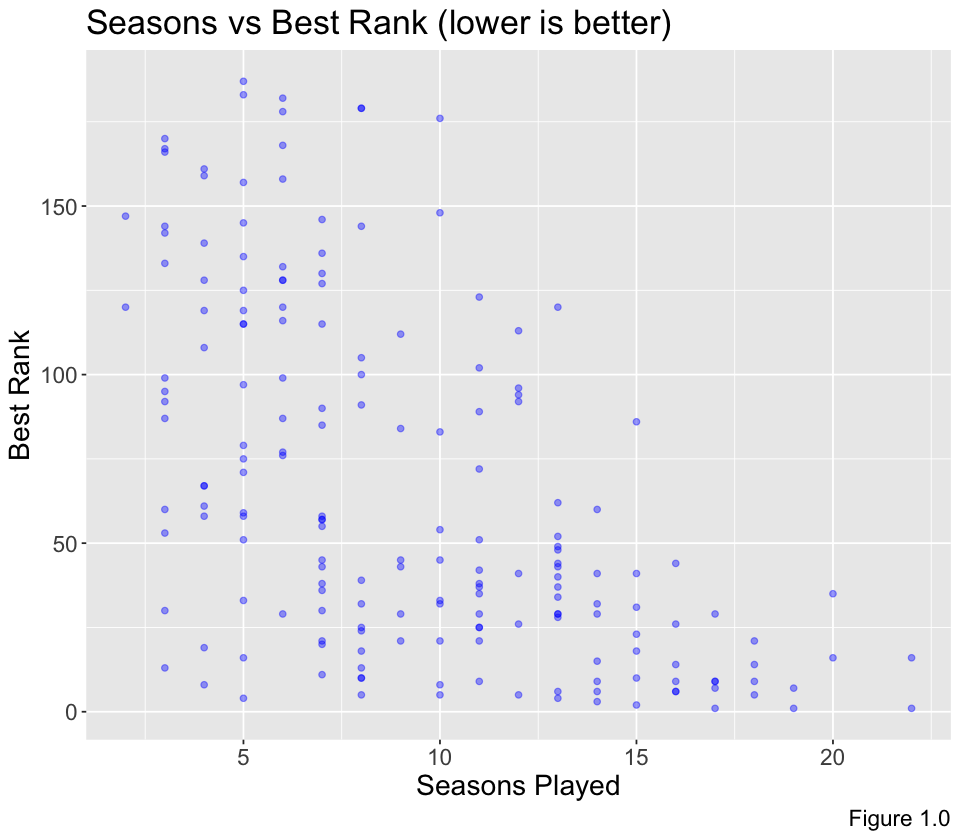

In [26]:
options(repr.plot.length = 10, repr.plot.width = 8)

SeasonsVsBestRank <- ggplot(player_data_tidy, aes(x = Seasons, y = Best.Rank)) + 
                    # geom_smooth(method = "lm", colour = "red", formula = y ~ x, se = FALSE) + #Line of best fit, helps in seeing relationship
                    geom_point(colour = "blue", alpha = 0.4) +
                     labs(x = "Seasons Played", y = "Best Rank", 
                          title = "Seasons vs Best Rank (lower is better)",
                          caption = "Figure 1.0") + 
                     theme(text = element_text(size = 17))

SeasonsVsBestRank

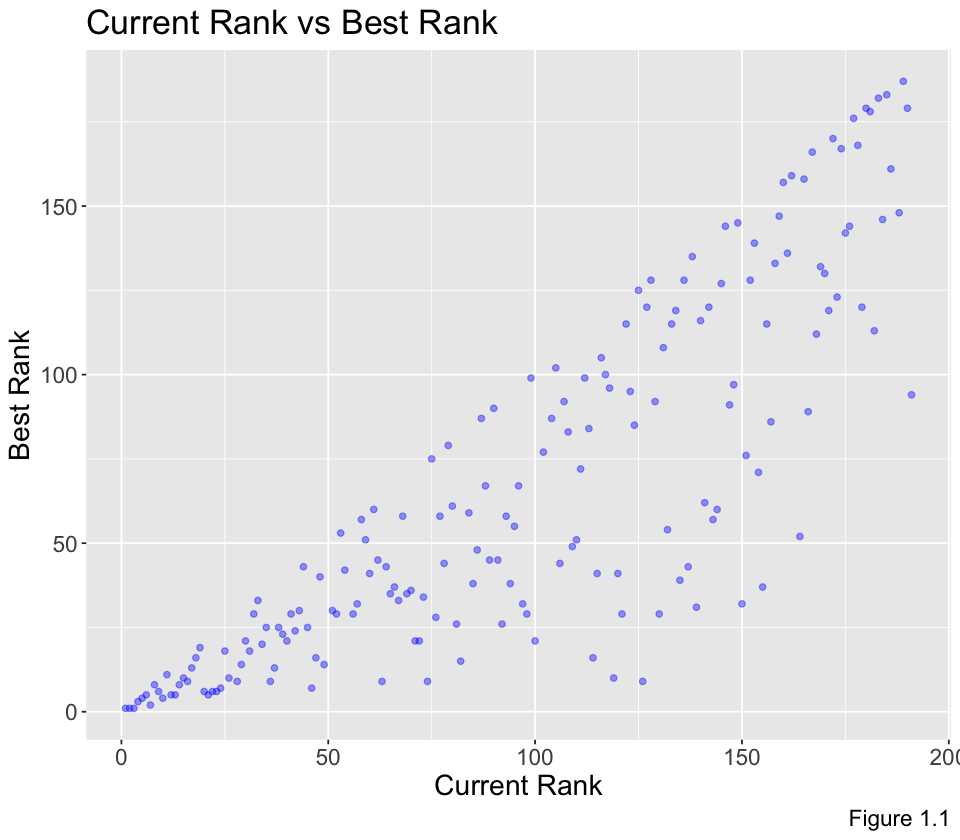

In [27]:
CurrentRankVsBestRank <- ggplot(player_data_tidy, aes(x = Current.Rank, y = Best.Rank)) + 
                    geom_point(color = "blue", alpha = 0.4) +
                     labs(x = "Current Rank", y = "Best Rank",
                          title = "Current Rank vs Best Rank",
                          caption = "Figure 1.1") + 
                     theme(text = element_text(size = 17)) 

CurrentRankVsBestRank

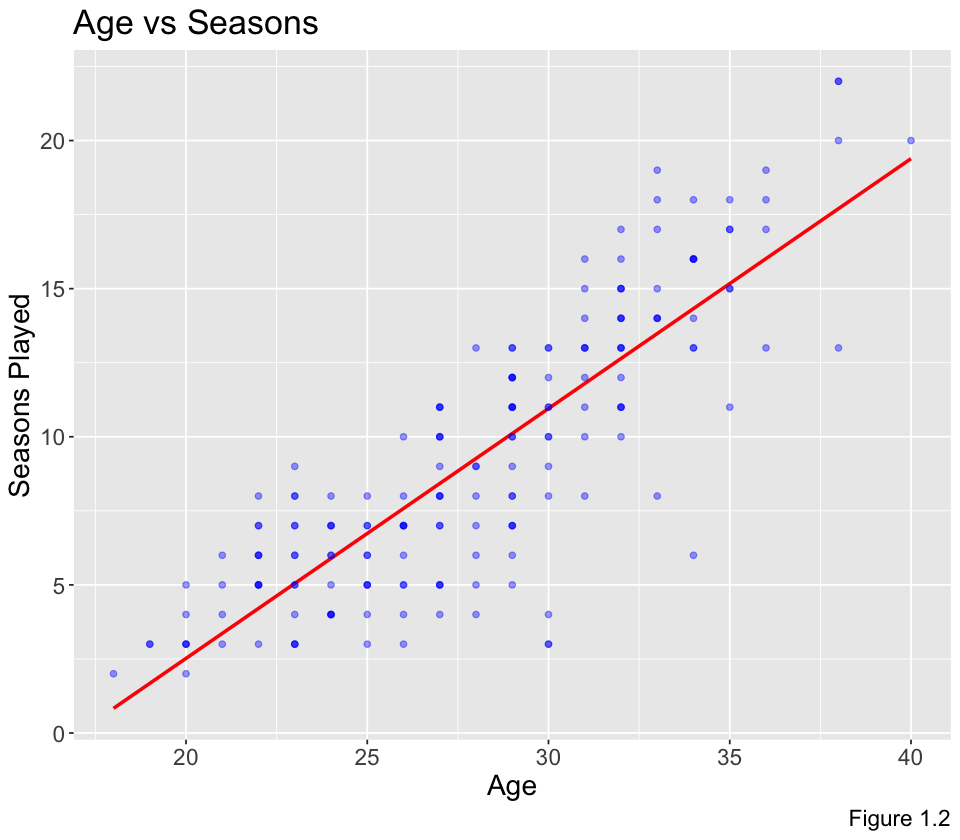

In [42]:
AgeVsSeasons <- ggplot(player_data_tidy, aes(x = Age, y = Seasons)) + 
                    geom_smooth(method = "lm", colour = "red", formula = y ~ x, se = FALSE) + #Line of best fit, helps in seeing relationship
                    geom_point(color = "blue", alpha = 0.4) +
                     labs(x = "Age", y = "Seasons Played",
                          title = "Age vs Seasons",
                          caption = "Figure 1.2") + 
                     theme(text = element_text(size = 17)) 

AgeVsSeasons

In this plot, we can see that the variables Age and seasons are very strongly correlated and have a close relationship with each other. Due to this relationship, multicollinearity can be caused and can lead to problems. That is the reason why we dont use Age as a predictor variable in the prediction of Rank.

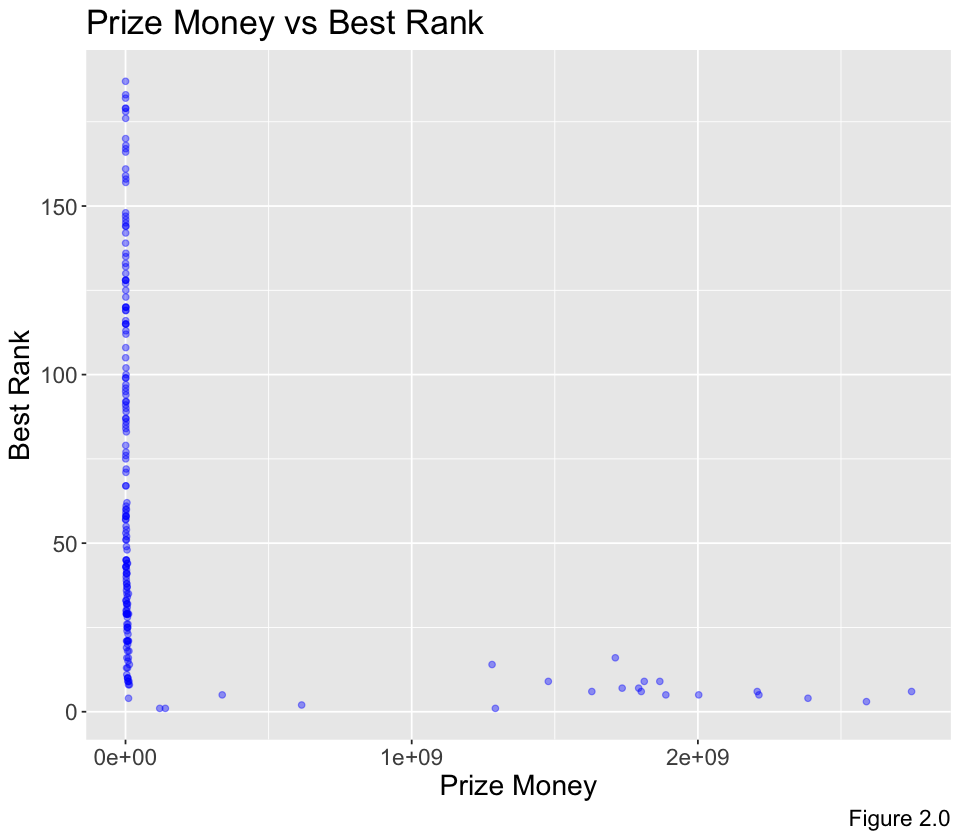

In [29]:
PrizeMoneyVsBestRank <- ggplot(player_data_tidy, aes(x = Prize.Money, y = Best.Rank)) + 
                    geom_point(color = "blue", alpha = 0.4) +
                     labs(x = "Prize Money", y = "Best Rank",
                          title = "Prize Money vs Best Rank",
                          caption = "Figure 2.0") +  
                     theme(text = element_text(size = 17))

PrizeMoneyVsBestRank

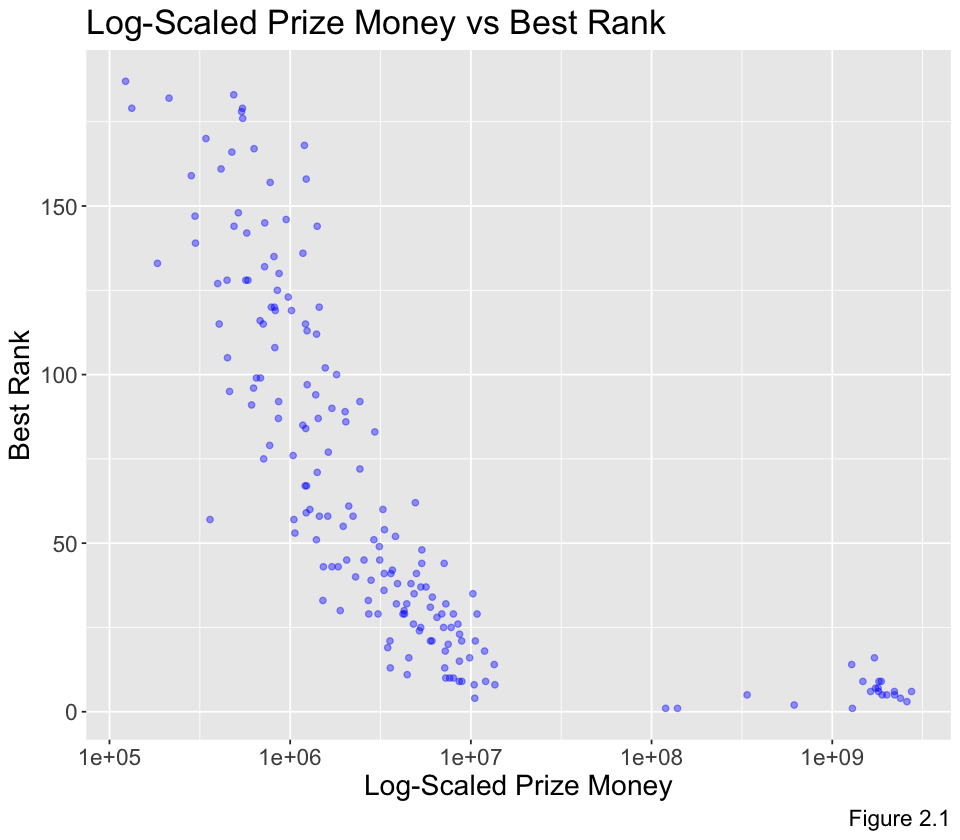

In [30]:
LogPrizeMoneyVsBestRank <- ggplot(player_data_tidy, aes(x = Prize.Money, y = Best.Rank)) + 
                    geom_point(color = "blue", alpha = 0.4) +
                     labs(x = "Log-Scaled Prize Money", y = "Best Rank",
                          title = "Log-Scaled Prize Money vs Best Rank",
                          caption = "Figure 2.1") +  
                     theme(text = element_text(size = 17)) +
                     scale_x_log10()

LogPrizeMoneyVsBestRank

In [32]:
log_player_data_tidy <- player_data_tidy %>%
                            mutate(Prize.Money = log(Prize.Money))

In [33]:
set.seed(4747)


player_split <- initial_split(log_player_data_tidy)
player_training <- training(player_split)
player_testing <- testing(player_split)

In [35]:
set.seed(4747)

player_vfold <- vfold_cv(player_training, v = 5, strata = Best.Rank)
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 1))

player_recipe <- recipe(Best.Rank ~ Seasons + Prize.Money + Current.Rank, data = player_training) %>% 
                        step_scale(all_predictors()) %>%
                        step_center(all_predictors())

knn_spec_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
                set_engine("kknn") %>%
                set_mode("regression")

player_resamples_metrics <- workflow() %>%
                            add_model(knn_spec_tune) %>%
                            add_recipe(player_recipe) %>%
                            tune_grid(resamples = player_vfold, grid = k_vals) %>%
                            collect_metrics()

In [37]:
resamples_metrics_clean <- player_resamples_metrics %>%
                                filter(.metric == "rmse") %>%
                                arrange(mean) %>%
                                slice(1) %>%
                                select(-.estimator, -n, -.config)

kable(resamples_metrics_clean, caption = "Table 2.0")



Table: Table 2.0

| neighbors|.metric |     mean|  std_err|
|---------:|:-------|--------:|--------:|
|        10|rmse    | 16.45332| 1.157192|

In [38]:
set.seed(4747)

best_k <- resamples_metrics_clean %>%
            select(neighbors) %>%
            pull()

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) %>%
                set_engine("kknn") %>%
                set_mode("regression")

knn_fit <- workflow() %>%
            add_model(knn_spec) %>%
            add_recipe(player_recipe) %>%
            fit(player_training) 

knn_predict <- predict(knn_fit, player_testing) %>%
                bind_cols(player_testing)

knn_metrics <- metrics(knn_predict, truth = Best.Rank, estimate = .pred)

knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(10,     data, 5), kernel = ~"rectangular")

Type of response variable: continuous
minimal mean absolute error: 12.34599
Minimal mean squared error: 279.4064
Best kernel: rectangular
Best k: 10

In [39]:
kable(head(knn_predict), 
      caption = "Table 3.0")



Table: Table 3.0

| .pred|Name                    | Age| Prize.Money| Seasons| Current.Rank| Best.Rank|
|-----:|:-----------------------|---:|-----------:|-------:|------------:|---------:|
|  31.1|Hubert Hurkacz          |  22|    14.23235|       5|           33|        33|
|   7.0|Juan Martin Del Potro   |  31|    21.67452|      14|            4|         3|
|  39.2|Marcel Granollers       |  33|    16.19701|      14|          121|        29|
|  25.2|Fabio Fognini           |  32|    16.41602|      16|           29|        14|
|  33.0|Robin Haase             |  32|    15.77764|      13|           78|        44|
|  66.6|Roberto Carballes Baena |  26|    14.34727|       7|           90|        90|

In [40]:
kable(head(knn_metrics), 
      caption = "Table 3.1")



Table: Table 3.1

|.metric |.estimator |  .estimate|
|:-------|:----------|----------:|
|rmse    |standard   | 18.1065986|
|rsq     |standard   |  0.8399648|
|mae     |standard   | 12.6065217|

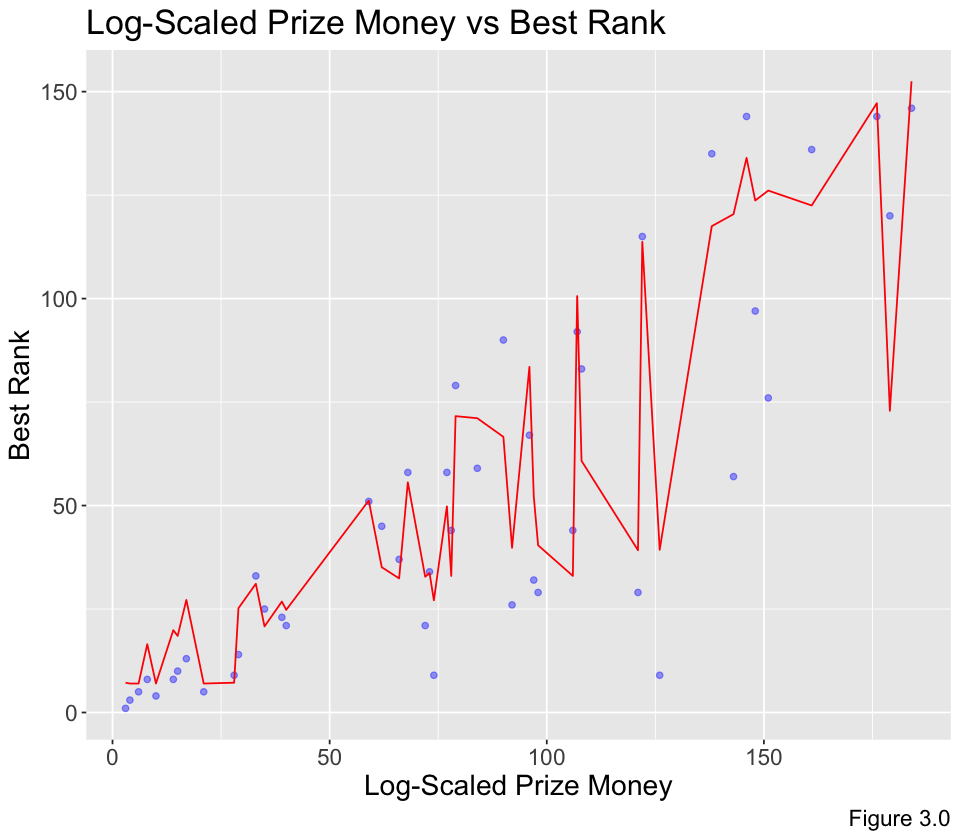

In [41]:
PredPlot <- ggplot(knn_predict, aes(x = Current.Rank, y = Best.Rank)) + 
                    geom_point(color = "blue", alpha = 0.4) +
                    geom_line(aes(x = Current.Rank, y = .pred), color = "red") +
                     labs(x = "Log-Scaled Prize Money", y = "Best Rank",
                          title = "Log-Scaled Prize Money vs Best Rank",
                          caption = "Figure 3.0") +  
                     theme(text = element_text(size = 17))

PredPlot

**References**
1. Tennis Scoring: Points, Sets & Games | Tennis Rules | USTA. (n.d.). Tennis Scoring: Points, Sets & Games | Tennis Rules | USTA. https://www.usta.com/en/home/improve/tips-and-instruction/national/tennis-scoring-rules.html.